# Solving a 1st-order PDE BVP with a neural network

## Setup

In [1]:
%%javascript
MathJax.Hub.Config({
      TeX: { equationNumbers: { autoNumber: "AMS" } }
    });MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

In [2]:
from math import exp
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Introduction

This notebook will demonstrate how to use the code in the `nnpde1ivp.py` module. The module allows the user to solve 1st-order partial differential equation (PDE) initial value problems (IVPs) with two variables using a single-hidden layer neural network.

This work is based on the paper ["Artificial Neural Networks for Solving Ordinary and Partial Differential Equations", by Lagaris et al, *IEEE Transactions on Neural Networks, Volume 9, No. 5*, September 1998](http://ieeexplore.ieee.org/document/712178/). Note that the notation used in this notebook and the associated Python code differs slightly from that used in the Lagaris paper.

## The algorithm

Consider an $m$-dimensional space containing vectors $\vec x = (x_1,x_2,...,x_m)$. Any 1st-order PDE for the scalar function $\psi(\vec x)$ can be written in the form:

\begin{equation}
G(\vec x,\psi,\vec \nabla \psi) = 0
\end{equation}

The problem is to find a solution $\psi (\vec x)$ to the PDE using a neural network, subject to the initial conditions:

\begin{equation}
\psi(0,x_2,x_3,...)=A_1(\vec x)
\end{equation}

\begin{equation}
\psi(x_1,0,x_3,...)=A_2(\vec x), etc.
\end{equation}

The network is trained using a set of $n$ training points $\vec x_i$ ($1 \le i \le n$), defined over the domain of interest. This work assumes that the vectors $\vec x_i$ have been scaled so that each component $x_{ij} \in [0,1]$, $1 \leq j \leq m$. The training points need not be evenly-spaced. Note that only the independent variable vectors $\vec x_i$  of the training points are needed - the estimated value of the solution at the training points is obtained using a trial solution $\psi_t$ of the form:

\begin{equation}
\psi_t(\vec x_i,\vec p) = A(\vec x_i) + P(\vec x_i) N(\vec x_i,\vec p)
\end{equation}

or:

\begin{equation}
\psi_{ti} = A_i + P_i N_i
\end{equation}

where $\psi_{ti}$ is the value of the trial solution at the current training point $\vec x_i$, $A_i$ is a function which yields the initial conditions at the origin of each dimension, $P_i$ is a function which vanishes at the origin of each dimension, and $N_i$ is the floating-point single-valued output from an unspecified neural network with network parameters $\vec p$. Note that this trial solution satisfies the boundary conditions by construction - wherever any coordinate is 0, the second term vanishes, leaving $\psi_t(\vec x_i, \vec p_i)=A(\vec x_i)$, which is just the specified initial condition for that coordinate. The PDE is assumed to have been preprocessed so that all boundary conditions lie at the origin. For a 2-variable PDE with independent variables $x$ and $y$, this condition is represented by:

\begin{equation}
\psi_t(0,y,\vec p) = f_0(y)
\end{equation}

\begin{equation}
\psi_t(x,0,\vec p) = g_0(x)
\end{equation}

The analytical forms of $A(\vec x_i)$ and $P(\vec x_i)$ are constructed to meet these requirements, and noting that, by continuity at the origin, $f_0(0)=g_0(0)$. For a 2-variable PDE, we have:

\begin{equation}
A(x,y) = (1-x)f_0(y) + (1-y)(g_0(x) - (1-x)g_0(0))
\end{equation}

\begin{equation}
P(x,y) = xy
\end{equation}

These functions rapidly become more complex as the number of problem dimensions is increased, so this example will utilize a 2-variable PDE. Training is done in a set of *epochs*. A training epoch consists of presenting the neural network with each of the $n$ training points $\vec x_i$, one at a time. For each input point $\vec x_i$, the network output $N_i$ is computed. Once all $n$ points have been presented, the epoch is complete, and the error function $E$ is computed. The problem definition provides an analytical form for the error function, as the sum of squared errors (SSE) for each of the training points:

\begin{equation}
E = \sum_{i=1}^{n} \left( G(\vec x_i,\psi_{ti}, \vec \nabla \psi_{ti}) \right)^2 =
\sum_{i=1}^{n} G_i^2
\end{equation}

Once this error function is computed, the parameters in the neural network are adjusted to reduce the error. Eventually, a minimum of $E$ is attained, and the resulting final form of $\psi_t(x)$ is used as the solution to the original PDE.

## Computing the network output $N_i$

The neural network used in this work has a simple structure. One input node for each component of $\vec x_i$ is used (for a total of $m$ input nodes) to provide the training data. Each input node is fully-connected to each of a set of $H$ hidden nodes, each using a sigmoid transfer function. Each hidden node is connected to the single output node, which uses a linear transfer function with a weight for the signal from each hidden node.

During each step of a training epoch, the input to the network is just the training point $\vec x_i$. Each input node $j$ receives one component $x_{ij}$, and emits that value as output. These outputs are sent to each of the $H$ hidden nodes. At each hidden node $k$, the input values $x_{ij}$ are combined and scaled by the equation:

\begin{equation}
z_{ik} = \sum_{j=1}^m w_{jk} x_{ij} + u_k
\end{equation}

where  $w_{jk}$ is the weight for input node $j$ at hidden node $k$, and $u_k$ is the bias at hidden node $k$. This combined value is then used as the input to a sigmoidal transfer function:

\begin{equation}
\sigma_{ik} = \sigma(z_{ik})
\end{equation}

where:

\begin{equation}
\sigma(z) = \frac {1}{1+e^{-z}}
\end{equation}

A plot of this transfer function and its first three derivatives is provided below.

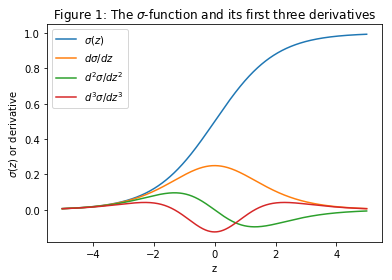

In [3]:
def sigma(z):
    return 1 / (1 + exp(-z))

def dsigma_dz(z):
    return exp(-z) / (1 + exp(-z))**2

def d2sigma_dz2(z):
    return (
        2 * exp(-2 * z) / (1 + exp(-z))**3 - exp(-z) / (1 + exp(-z))**2
    )

def d3sigma_dz3(z):
    return (
        6 * exp(-3 * z) / (1 + exp(-z))**4
        - 6 * exp(-2 * z) / (1 + exp(-z))**3
        + exp(-z) / (1 + exp(-z))**2
    )

z = np.arange(-5, 5, 0.01)
n = len(z)
s = np.zeros(n)
ds_dz = np.zeros(n)
d2s_dz2 = np.zeros(n)
d3s_dz3 = np.zeros(n)
for i in range(n):
    s[i] = sigma(z[i])
    ds_dz[i] = dsigma_dz(z[i])
    d2s_dz2[i] = d2sigma_dz2(z[i])
    d3s_dz3[i] = d3sigma_dz3(z[i])
plt.plot(z,s,label = "$\sigma(z)$")
plt.plot(z,ds_dz,label = "$d\sigma/dz$")
plt.plot(z,d2s_dz2, label = "$d^2\sigma/dz^2$")
plt.plot(z,d3s_dz3, label = "$d^3\sigma/dz^3$");
plt.xlabel("z")
plt.ylabel("$\sigma(z)$ or derivative")
plt.title("Figure 1: The $\sigma$-function and its first three derivatives")
plt.legend();

Once the $\sigma_{ik}$ are computed, they are all passed to the single output node, where they are processed by a linear transfer function to create the network output for the current input point $\vec x_i$:

\begin{equation}
N_i = \sum_{k=1}^{H}v_k\sigma_{ik}
\end{equation}

where $v_k$ is the weight applied to the output from hidden node $k$ at the output node. Once $N_i$ has been computed, the trial function $\psi_{ti}$ is computed. To compute the value of $G_i$ (and thus $E$), we also need the gradient of the trial function $\vec \nabla \psi_{ti}$.

\begin{equation}
\vec \nabla \psi_{ti} = \vec \nabla (A_i + P_i N_i)
\end{equation}

Each component $j$ of this gradient may be written as:

\begin{equation}
\frac {\partial \psi_{ti}}{\partial x_{ij}} =
\frac {\partial A_i}{\partial x_{ij}} + P_i \frac {\partial N_i}{\partial x_{ij}} + \frac {\partial P_i}{\partial x_{ij}} N_i
\end{equation}

The functional forms of the derivatives of $A_i$ and $P_i$ with respect to $x_{ij}$ are computed $\it a \ priori$ from their known analytical forms, which may vary based on the problem under investigation. The values of the network output derivatives $\frac {\partial N_i}{\partial x_{ij}}$ are computed analytically using the known form of the network and its weights and biases.

\begin{equation}
\frac {\partial N_i}{\partial x_{ij}} =
\frac {\partial}{\partial x_{ij}} \sum_{k=1}^{H} v_k \sigma_{ik} =
\sum_{k=1}^{H} v_k \frac {\partial \sigma_{ik}}{\partial x_{ij}} =
\sum_{k=1}^{H} v_k \frac {\partial \sigma_{ik}}{\partial z_{ik}} \frac {\partial z_{ik}}{\partial x_{ij}} = \sum_{k=1}^{H} v_k \sigma_{ik}^{(1)} w_{jk}
\end{equation}

where the derivatives of $\sigma$ are given by:

\begin{equation}
\sigma^{(k)} = \frac {d^k \sigma}{dz^k}
\end{equation}

With the values of $\psi_{ti}$ and $\vec \nabla \psi_{ti}$, we can now compute the values of $G_i$, and then the error function $E$ for the current epoch.

## Updating the network parameters

The network parameters are the weights and biases of the hidden and output nodes. For an $m$-dimensional input point $\vec x_i$, and a set of $H$ hidden nodes, we have a total of $N_p = (m+2)H$ parameters in total: a weight for each $x_{ij}$ for each hidden node, a bias for each hidden node, and an output weight for each hidden node.

Since the objective function to minimize is the error $E$, the value of each network parameter $p$ (where $p$ represents $v_k$, $u_k$, or $w_{jk}$) is updated using a scaled Newton's method:

\begin{equation}
p_{new}=p - \eta \frac {\partial E} {\partial p}
\end{equation}

where $\eta$ is the *learning rate*. The learning rate is used to control the rate of convergence. The derivatives of $E$ are computed using the known form of $G_i$, the network, and the network parameters.

This process of parameter updates is repeated until the specified maximum number of training epochs has been applied. Note that the same set of training points is presented during each epoch.

## Computing the derivatives of $E$

The partial derivatives of $E$ with respect to any network parameter $p$ are given by:

\begin{equation}
\frac {\partial E}{\partial p} =
2 \sum_{i=1}^n G_i \frac {\partial G_i}{\partial p}
\end{equation}

## Computing the derivatives of $G_i$

The partial derivatives of $G_i$ with respect to $x_{ij}$, $\psi_{ti}$, and $\frac {\partial \psi_{ti}} {\partial x_{ij}}$ are determined $\it a\ priori$ from the analytical form of $G$ using the chain rule. Note also that $\frac {\partial x_{ij}} {\partial p_{hk}} = 0$. The remaining partial derivatives of $G_i$ are:

\begin{equation}
\frac {\partial G_i}{\partial p} =
\frac {\partial G_i}{\partial \psi_{ti}} \frac {\partial \psi_{ti}}{\partial p} +
\sum_{j=1}^m \frac {\partial G_i}{\partial \left(\frac {\partial \psi_{ti}}{\partial x_{ij}}\right)}
\frac {\partial^2 \psi_{ti}}{\partial p \partial x_{ij}}
\end{equation}

Note that the partials of $G_i$ by $\psi$ and $\vec \nabla \psi$ must be supplied in anaytical form, since the analytical form of $G_i(\vec x,\psi,\vec \nabla \psi)$ is known. Partials of these partials by parameters $p$ are found using the chain rule.

## Computing the derivatives of $\psi_{ti}$

 The derivatives of the trial solution $\psi_{t}$ are given by:

\begin{equation}
\frac {\partial \psi_{ti}} {\partial p} = \
P_i \frac {\partial N_i} {\partial p}
\end{equation}

\begin{equation}
\frac {\partial^2 \psi_{ti}} {\partial p \partial x_{ij}} = \
P_i \frac {\partial^2 N_i} {\partial p \partial x_{ij}} + \
\frac {\partial P_i} {\partial x_{ij}} \frac {\partial N_i} {\partial p}
\end{equation}

Note that $A_i$ and $P_i$ are independent of the network parameters $p$.

## Computing the derivatives of $N_i$

The partial derivatives of $N_i$ are:

\begin{equation}
\frac {\partial N_i} {\partial x_{ij}} = \sum_{k=1}^H v_k \sigma_{ik}^{(1)} w_{jk}
\end{equation}

\begin{equation}
\frac {\partial N_i} {\partial p} =
\sum_{k=1}^H \left ( v_k \sigma_{ik}^{(1)} \frac {\partial z_{ik}} {\partial p} +
\frac {\partial v_k} {\partial p} \sigma_{ik} \right )
\end{equation}

\begin{equation}
\frac {\partial^2 N_i}{\partial p \partial x_{ij}} =
\sum_{k=1}^{H} \left(
v_k \sigma_{ik}^{(1)} \frac {\partial w_{jk}} {\partial p} + \
v_k \sigma_{ik}^{(2)} \frac {\partial z_{ik}} {\partial p} w_{jk} + \
\frac {\partial v_k} {\partial p} \sigma_{ik}^{(1)} w_{jk}
\right)
\end{equation}

Most of these expressions can now be simplified using the following relations between the network parameters ($*$ means any index or combination of indices):

\begin{equation}
\frac {\partial v_k}{\partial v_l} = \delta_{kl},
\frac {\partial v_k}{\partial w_*} = \frac {\partial v_k}{\partial u_*} = 0
\end{equation}


\begin{equation}
\frac {\partial u_k}{\partial u_l} = \delta_{kl},
\frac {\partial u_k}{\partial v_*} = \frac {\partial u_k}{\partial w_*} = 0
\end{equation}

\begin{equation}
\frac {\partial w_{jk}}{\partial w_{hl}} = \delta_{jh} \delta_{kl},
\frac {\partial w_{jk}}{\partial v_*} = \frac {\partial w_{jk}}{\partial u_*} = 0
\end{equation}

\begin{equation}
\frac {\partial z_{ik}}{\partial v_*} = 0,
\frac {\partial z_{ik}}{\partial w_{jl}} = x_{ij} \delta_{kl},
\frac {\partial z_{ik}}{\partial u_l} = \delta_{kl},
\end{equation}

# Walking through an example problem

Consider the simple 1st-order partial differential equation:

\begin{equation}
G(\vec x, \psi, \vec \nabla \psi) = xy - \psi = 0
\end{equation}

In Python form:

In [4]:
def Gf(xy, psi, del_psi):
    (x, y) = xy
    return x * y - psi

The analytical solution to this PDE is:

\begin{equation}
\psi(x,y) = xy
\end{equation}

This function is plotted in the following figure:

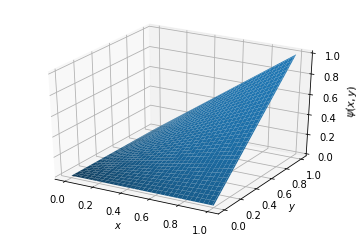

In [5]:
fig = plt.figure()
ax = fig.gca(projection = '3d')
x = np.linspace(0,1,101)
y = np.linspace(0,1,101)
x,y = np.meshgrid(x,y)
psi = x*y
z = psi.reshape(x.shape)
surf = ax.plot_surface(x, y, z)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$\psi(x,y)$');

We need to specify quite a few derivatives, but most of them vanish. To begin, the first partials of $G(\vec x,\psi,\vec \nabla \psi)$:

\begin{equation}
\frac {\partial G} {\partial x} = y
\end{equation}

\begin{equation}
\frac {\partial G} {\partial y} = x
\end{equation}

In Python form, these equations are (unused arguments are ignored):

In [6]:
def dG_dxf(xy,psi,del_psi):
    (x,y) = xy
    return y

In [7]:
def dG_dyf(xy, psi, del_psi):
    (x, y) = xy
    return x

In [8]:
del_Gf = (dG_dxf,dG_dyf)

\begin{equation}
\frac {\partial G} {\partial \psi} = -1
\end{equation}

In Python form:

In [9]:
def dG_dpsif(xy, psi, del_psi):
    return -1

\begin{equation}
\frac {\partial G} {\partial \left ( \frac {\partial \psi} {\partial x} \right )} = 0
\end{equation}

\begin{equation}
\frac {\partial G} {\partial \left ( \frac {\partial \psi} {\partial y} \right )} = 0
\end{equation}

In Python form:

In [10]:
def dG_dpsi_dxf(xy, psi, del_psi):
    return 0

In [11]:
def dG_dpsi_dyf(xy, psi, del_psi):
    return 0

In [12]:
dG_ddel_psif = (dG_dpsi_dxf,dG_dpsi_dyf)

The boundary condition functions and their required derivatives are:

\begin{equation}
f_0(y)=0
\end{equation}

\begin{equation}
g_0(x)=0
\end{equation}

In [13]:
def f0f(y):
    return 0

In [14]:
def g0f(x):
    return 0

In [15]:
bcf = (f0f,g0f)

\begin{equation}
\frac {\partial f_0} {\partial y} = 0
\end{equation}

\begin{equation}
\frac {\partial g_0} {\partial x} = 0
\end{equation}

In [16]:
def df0_dyf(y):
    return 0

In [17]:
def dg0_dxf(x):
    return 0

In [18]:
bcdf = (df0_dyf, dg0_dxf)

Now that we have the forms for all of these derivatives and boundary conditions, we can create the training points. Use an evenly-spaced grid of 25 points.

In [19]:
nxy = 5
dxy = 1 / nxy
x = np.zeros((nxy**2, 2))
for j in range(nxy):
    for i in range(nxy):
        k = j * nxy + i
        x[k][0] = i * dxy
        x[k][1] = j * dxy

Call the function which solves the ODE. Use 10 nodes in the hidden layer, and 1000 training epochs, a learning rate of 0.01, and activate verbose output.

In [20]:
np.random.seed(0)
from nnpde1 import nnpde1
(psit,del_psit) = nnpde1(
        Gf,             # 2-variable, 1st-order PDE IVP to solve
        bcf,            # BC functions
        bcdf,           # BC function derivatives
        dG_dpsif,       # Partial of G wrt psi
        del_Gf,         # Gradient of G
        dG_ddel_psif,   # Partials of G wrt del psi
        x,              # Training points as pairs
        nhid = 10,      # Node count in hidden layer
        maxepochs = 1000, # Max training epochs
        eta = 0.01,     # Learning rate
        debug = False,
        verbose = True
    )

0 0.026102683822766152
1 0.023764413782468186
2 0.021770135548417103
3 0.020080109347449516
4 0.018657900446516454
5 0.01746991194267333
6 0.01648511241146616
7 0.015674934412945443
8 0.015013293660753487
9 0.014476663165053172
10 0.014044138076528797
11 0.01369744384837252
12 0.013420865066974041
13 0.013201095809121741
14 0.013027028513574767
15 0.0128895054218687
16 0.012781056351981181
17 0.012695641976438249
18 0.012628415689703498
19 0.012575511415973746
20 0.012533860200197394
21 0.012501035329732279
22 0.012475123875691167
23 0.012454621616418212
24 0.012438348007319865
25 0.01242537794532737
26 0.012414987365351099
27 0.012406610083403592
28 0.012399803695675822
29 0.012394222715553734
30 0.012389597462616435
31 0.012385717502682846
32 0.01238241867651374
33 0.01237957295087139
34 0.012377080484761278
35 0.012374863431561477
36 0.012372861099787484
37 0.01237102617621583
38 0.012369321779086478
39 0.012367719159520065
40 0.012366195908904412
41 0.01236473456108464
42 0.0123633

359 0.011978130934446139
360 0.011976946863620429
361 0.011975762971346986
362 0.011974579257582173
363 0.011973395722282367
364 0.011972212365404026
365 0.011971029186903468
366 0.011969846186737165
367 0.01196866336486156
368 0.01196748072123312
369 0.011966298255808298
370 0.01196511596854359
371 0.011963933859395495
372 0.011962751928320515
373 0.011961570175275204
374 0.011960388600216063
375 0.011959207203099674
376 0.011958025983882617
377 0.011956844942521474
378 0.011955664078972823
379 0.011954483393193301
380 0.011953302885139584
381 0.011952122554768218
382 0.011950942402035947
383 0.011949762426899397
384 0.011948582629315264
385 0.011947403009240246
386 0.011946223566631086
387 0.011945044301444482
388 0.011943865213637224
389 0.01194268630316602
390 0.01194150756998768
391 0.011940329014058969
392 0.011939150635336706
393 0.011937972433777718
394 0.011936794409338817
395 0.011935616561976857
396 0.011934438891648686
397 0.01193326139831121
398 0.011932084081921273
399 0.

705 0.011578809026309304
706 0.011577684226688343
707 0.011576559591352748
708 0.011575435120263556
709 0.011574310813381897
710 0.011573186670668808
711 0.01157206269208544
712 0.011570938877592878
713 0.011569815227152237
714 0.011568691740724717
715 0.011567568418271406
716 0.011566445259753472
717 0.011565322265132159
718 0.011564199434368599
719 0.011563076767423994
720 0.011561954264259596
721 0.011560831924836605
722 0.011559709749116265
723 0.011558587737059842
724 0.0115574658886286
725 0.011556344203783793
726 0.011555222682486745
727 0.011554101324698763
728 0.011552980130381104
729 0.011551859099495194
730 0.011550738232002294
731 0.011549617527863765
732 0.011548496987040996
733 0.011547376609495367
734 0.011546256395188257
735 0.011545136344081105
736 0.011544016456135264
737 0.011542896731312225
738 0.011541777169573362
739 0.01154065777088022
740 0.011539538535194164
741 0.011538419462476756
742 0.01153730055268942
743 0.01153618180579371
744 0.01153506322175109
745 0.0

Compare the computed values with the analytical values.

In [21]:
def psiaf(xy):
    (x, y) = xy
    return x * y

In [22]:
def dpsia_dxf(xy):
    (x, y) = xy
    return y

In [23]:
def dpsia_dyf(xy):
    (x, y) = xy
    return x

In [24]:
del_psiaf = ( dpsia_dxf, dpsia_dyf )

In [25]:
psia = np.zeros(len(x))
for i in range(len(x)):
    psia[i] = psiaf(x[i])

In [26]:
del_psia = np.zeros((len(x), len(x[1])))
for i in range(len(x)):
    for j in range(len(x[0])):
        del_psia[i][j] = del_psiaf[j](x[i])

Compute the RMS error of the computed solution and its partial derivatives.

In [27]:
from math import sqrt
psi_err = psit - psia
rmse_psi = sqrt(sum(psi_err**2) / len(x))

In [28]:
del_psi_err = del_psit - del_psia
rmse_del_psi = np.zeros(len(x[0]))
e2sum = np.zeros(len(x[0]))
for j in range(len(x[0])):
    for i in range(len(x)):
        e2sum[j] += del_psi_err[i][j]**2
    rmse_del_psi[j] = sqrt(e2sum[j] / len(x))

Compare the results.

In [29]:
print('    x        y      psia     psit   dpsia_dx dpsia_dy dpsit_dx dpsit_dy')
for i in range(len(psia)):
    print('%.6f %.6f %.6f %.6f %.6f %.6f %.6f %.6f' %
          (x[i][0], x[i][1],
           psia[i], psit[i],
           del_psia[i][0], del_psit[i][0],
           del_psia[i][1], del_psit[i][1])
        )
print('RMSE      %f          %f     %f' % 
      (rmse_psi, rmse_del_psi[0], rmse_del_psi[1]))

    x        y      psia     psit   dpsia_dx dpsia_dy dpsit_dx dpsit_dy
0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
0.200000 0.000000 0.000000 0.000000 0.000000 0.000000 0.200000 0.150098
0.400000 0.000000 0.000000 0.000000 0.000000 0.000000 0.400000 0.321541
0.600000 0.000000 0.000000 0.000000 0.000000 0.000000 0.600000 0.513012
0.800000 0.000000 0.000000 0.000000 0.000000 0.000000 0.800000 0.722798
0.000000 0.200000 0.000000 0.000000 0.200000 0.148384 0.000000 0.000000
0.200000 0.200000 0.040000 0.031836 0.200000 0.169795 0.200000 0.168062
0.400000 0.200000 0.080000 0.067832 0.200000 0.189916 0.400000 0.356343
0.600000 0.200000 0.120000 0.107689 0.200000 0.208348 0.600000 0.563174
0.800000 0.200000 0.160000 0.151040 0.200000 0.224814 0.800000 0.786610
0.000000 0.400000 0.000000 0.000000 0.400000 0.314610 0.000000 0.000000
0.200000 0.400000 0.080000 0.067141 0.400000 0.356374 0.200000 0.184763
0.400000 0.400000 0.160000 0.142353 0.400000 0.395193 0.400000 0